In [1]:
#Import our dependencies
import sqlalchemy
from sqlalchemy import Column, Integer, String, Float, inspect

#Used for connection with postgresql
import psycopg2
from sqlalchemy.ext.automap import automap_base

# For our data analysis
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Our hidden password
from config import pgadmin_pass

In [20]:
# The statement to connect with a postgresql database is somewhat more complicated than sqlite but here it is
# It attaches to a given username on the server with a password and then connects to the indicated database
engine = sqlalchemy.create_engine(sqlalchemy.engine.url.URL(
        drivername="postgresql",
        username="mgood13",
        password=pgadmin_pass,
        host="localhost",
        port="5432",
        database="employee_database",
    ),
    echo_pool=True,
)


In [4]:
# Setting up an automapped base which will detect our table objects for later usage
Base = automap_base()

In [5]:
# Use the Base class to reflect the database tables so that they can be accessed here
Base.prepare(engine, reflect=True)

In [7]:
# Establish a connection to the database engine which will allow reading these database tables into pandas
conn = engine.connect()

In [8]:
# Initialize the inspect object to acquire our table names
inspector = inspect(engine)

In [9]:
# Get all of the table names in our database
inspector.get_table_names()

['dept_manager', 'salaries', 'titles', 'employees', 'dept_emp', 'departments']

In [10]:
# Read all the tables into dataframe objects
dept_manager_df = pd.read_sql_table('dept_manager',conn)
salaries_df = pd.read_sql_table('salaries',conn)
titles_df = pd.read_sql_table('titles',conn)
employees_df = pd.read_sql_table('employees',conn)
dept_emp_df = pd.read_sql_table('dept_emp',conn)
departments_df = pd.read_sql_table('departments',conn)

In [21]:
# Visualize the min and max of the salary column to inform our binning
print(salaries_df['salary'].max())
print(salaries_df['salary'].min())

129492
40000


In [11]:
# Divide salary into bins based upon the values that we uncovered by seraching for the min and max of the salary column
bins = [0, 30000, 40000, 50000,60000,70000,80000,90000,100000,125000,150000]

# Create names for each bin
group_names = ["30k-", "40k", "50k", "60k", "70k","80k","90k","100k","125k",'150k']

#Cut the salary column into the bins
salaries_df["salary bin"] = pd.cut(salaries_df["salary"], bins, labels=group_names, include_lowest=True)

In [12]:
# Display the dataframe to check that our bins were correctly assigned
salaries_df.head()

,emp_no,salary,salary bin
0,10001,60117,70k
1,10002,65828,70k
2,10003,40006,50k
3,10004,40054,50k
4,10005,78228,80k


In [13]:
# Group by the bins and count the number of people that fall into each bin
salaries_group = salaries_df.groupby('salary bin').count()
salaries_group = salaries_group.reset_index()

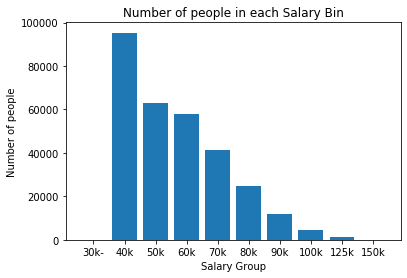

In [22]:
# All the columns of the dataframe except for salary bin are identical (they contain the count of people in a bin)
# so just pick one for the plot
plt.bar(salaries_group['salary bin'],salaries_group['salary'])
plt.title('Number of people in each Salary Bin')
plt.xlabel('Salary Group')
plt.ylabel('Number of people')
plt.show()

This does not immediately cause us great concern about the data. This is likely the structure of many companies who have a large pool of lower paid workers and increasingly small numbers of people in higher paying jobs.

In [15]:
# Check if there's a reasonable distribution of each salary
# Given the complexities of salary negotiation and the math of determining bonuses we expect that there shouldn't
# be any numbers that have an extraordinarily high count.
salaries_df['salary'].value_counts()

40000    95346
55581       19
53738       18
53078       18
47454       17
         ...  
74239        1
78148        1
76103        1
79114        1
81762        1
Name: salary, Length: 50355, dtype: int64

Our assumption about the distribution of values was shown to be incorrect and makes us think that this data isn't real data. The fact that over a third of the employees at the company make an identical amount of money isn't reasonable.

In [16]:
# Merge employees and salaries on the employee number column
merged_salary = pd.merge(employees_df,salaries_df, left_on = 'emp_no', right_on = 'emp_no')

# Display the dataframe to check if the merge happened in the way we expected
merged_salary.head()

,emp_no,emp_title_id,birth_date,first_name,last_name,sex,hire_date,salary,salary bin
0,473302,s0001,7/25/1953,Hideyuki,Zallocco,M,4/28/1990,40000,40k
1,475053,e0002,11/18/1954,Byong,Delgrande,F,9/7/1991,53422,60k
2,57444,e0002,1/30/1958,Berry,Babb,F,3/21/1992,48973,50k
3,421786,s0001,9/28/1957,Xiong,Verhoeff,M,11/26/1987,40000,40k
4,282238,e0003,10/28/1952,Abdelkader,Baumann,F,1/18/1991,40000,40k


In [17]:
# Group our data by title and calculate teh mean salary
merged_salary_group = merged_salary.groupby('emp_title_id').mean()

# Reset the index so that we can use it for plotting
merged_salary_group = merged_salary_group.reset_index()

# Display the dataframe (don't need to use head since it's a small dataframe)
merged_salary_group

,emp_title_id,salary
0,e0001,48564.434447
1,e0002,48535.336511
2,e0003,48506.799871
3,e0004,48582.896092
4,m0001,51531.041667
5,s0001,58465.382850
6,s0002,58550.172704


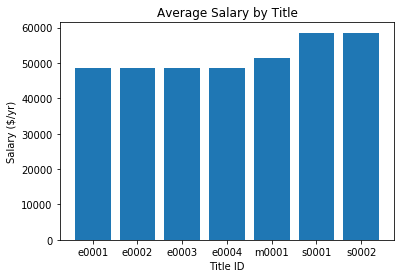

In [23]:
# Plot average salary by Title
plt.bar(merged_salary_group['emp_title_id'],merged_salary_group['salary'])
plt.title('Average Salary by Title')
plt.xlabel('Title ID')
plt.ylabel('Salary ($/yr)')
plt.show()

This data tells us one of two things about the company. The first is that there is very little monetary incentive to advance in the company as the average yearly salary increases by ~25% from the lowest engineer position to senior staff. The second, and far more likely, option is that this data was doctored in some way with random salaries without accounting for the salary brackets that would exist in the data of a real company.

In [19]:
# They got us!
# I'll be honest though, as someone who was really born in 1995 I have to say that it was pretty impressive
# of me to land a job at only 19 months old.
merged_salary.loc[merged_salary['emp_no'] == '499942',:]

,emp_no,emp_title_id,birth_date,first_name,last_name,sex,hire_date,salary,salary bin
168736,499942,e0004,1/10/1963,April,Foolsday,F,2/10/1997,40000,40k
